In [1]:
# === SEKCJA 1: IMPORT I KONFIGURACJA ===
import pandas as pd; import numpy as np; import re;
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from IPython.display import display
import matplotlib.pyplot as plt

print("Wczytywanie danych...")
df_main = pd.read_csv('data.csv', sep=',')
print("Dane wczytane.")

Wczytywanie danych...
Dane wczytane.


C:\Users\Ai\AppData\Local\Temp\ipykernel_17824\1122669041.py:16: DtypeWarning: Columns (15,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df_main = pd.read_csv('data.csv', sep=',')


In [2]:
# === SEKCJA 2: WCZYTANIE I PRZYGOTOWANIE DANYCH (POPRAWIONA) ===

print("Wczytywanie danych...")
df_main = pd.read_csv('data.csv', sep=',')
print("Dane wczytane.")

def extract_district(location_str):
    if not isinstance(location_str, str): return np.nan
    parts = [p.strip() for p in location_str.split(',')]
    if len(parts) >= 3 and 'warszawa' in parts[1].lower():
        return parts[2]
    return np.nan

df_processed = df_main.copy()
df_processed.dropna(subset=['Area', 'Price', 'Location'], inplace=True)
df_processed['District'] = df_processed['Location'].apply(extract_district)
df_processed.dropna(subset=['District'], inplace=True)
print(f"Po ekstrakcji dzielnic -> Pozostało wierszy: {len(df_processed)}, Unikalnych dzielnic: {df_processed['District'].nunique()}")

# --- Krok 2d (NOWOŚĆ): Filtrowanie rzadkich DZIELNIC ---
# Usuwamy dzielnice, które mają mniej niż 2 przykłady, aby umożliwić podział stratyfikowany
district_counts = df_processed['District'].value_counts()
districts_to_remove = district_counts[district_counts < 2].index
df_filtered_districts = df_processed[~df_processed['District'].isin(districts_to_remove)].copy()
print(f"Po odfiltrowaniu rzadkich dzielnic -> Pozostało wierszy: {len(df_filtered_districts)}, Unikalnych dzielnic: {df_filtered_districts['District'].nunique()}")


# --- Krok 2e: Finalne czyszczenie ---
df_filtered_districts['BuiltYear'] = pd.to_datetime(df_filtered_districts['BuiltYear'], format='%Y', errors='coerce')
q_low, q_hi = df_filtered_districts["Price"].quantile(0.01), df_filtered_districts["Price"].quantile(0.99)
df_final = df_filtered_districts[(df_filtered_districts["Price"] < q_hi) & (df_filtered_districts["Price"] > q_low)].copy()
print(f"Finalny zbiór danych gotowy. Liczba wierszy: {len(df_final)}")

Wczytywanie danych...


C:\Users\Ai\AppData\Local\Temp\ipykernel_17824\2316580170.py:4: DtypeWarning: Columns (15,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df_main = pd.read_csv('data.csv', sep=',')


Dane wczytane.
Po ekstrakcji dzielnic -> Pozostało wierszy: 120235, Unikalnych dzielnic: 39
Po odfiltrowaniu rzadkich dzielnic -> Pozostało wierszy: 120217, Unikalnych dzielnic: 21
Finalny zbiór danych gotowy. Liczba wierszy: 117804


In [3]:
# === SEKCJA 3: INŻYNIERIA CECH DO SIECI NEURONOWEJ ===

# --- 3a. Tekst ---
def clean_text(text): return re.sub(r'[^a-ząęółśżźćń ]', '', str(text).lower())
df_final['description_clean'] = df_final['Description'].apply(clean_text)

MAX_WORDS, MAX_LEN = 20000, 200
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(df_final['description_clean'])
sequences = tokenizer.texts_to_sequences(df_final['description_clean'])
X_text = pad_sequences(sequences, maxlen=MAX_LEN)
print(f"Kształt danych tekstowych (X_text): {X_text.shape}")

# --- 3b. Dane numeryczne ---
numeric_features = ['Area', 'Price', 'NumberOfRooms', 'Floor', 'Floors']
numeric_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
X_numeric = numeric_pipeline.fit_transform(df_final[numeric_features])
print(f"Kształt danych numerycznych (X_numeric): {X_numeric.shape}")

# --- 3c. Dane kategoryczne ---
# Dzielnica jest teraz celem, więc jej tu nie ma!
categorical_features = ['BuildingType']
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
X_categorical = cat_pipeline.fit_transform(df_final[categorical_features])
print(f"Kształt danych kategorycznych (X_categorical): {X_categorical.shape}")

# --- 3d. Przygotowanie celu (target) ---
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df_final['District']) # <-- ZMIANA TUTAJ
num_classes = len(label_encoder.classes_)
print(f"Liczba klas (dzielnic) do przewidzenia: {num_classes}")

Kształt danych tekstowych (X_text): (117804, 200)
Kształt danych numerycznych (X_numeric): (117804, 5)
Kształt danych kategorycznych (X_categorical): (117804, 5)
Liczba klas (dzielnic) do przewidzenia: 21


In [4]:
# === SEKCJA 4: BUDOWA I TRENING SIECI NEURONOWEJ ===

# Definicja architektury (pozostaje taka sama, jest wystarczająco potężna)
input_text = Input(shape=(MAX_LEN,), name='text_input')
input_numeric = Input(shape=(X_numeric.shape[1],), name='numeric_input')
input_categorical = Input(shape=(X_categorical.shape[1],), name='categorical_input')

embedding_layer = Embedding(input_dim=MAX_WORDS, output_dim=128, name='embedding')(input_text)
flatten_layer = Flatten()(embedding_layer)
concatenated = Concatenate()([flatten_layer, input_numeric, input_categorical])

x = Dense(512, activation='relu')(concatenated); x = BatchNormalization()(x); x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x); x = BatchNormalization()(x); x = Dropout(0.5)(x)
output_layer = Dense(num_classes, activation='softmax')(x) # num_classes będzie teraz mniejsze (~18)

model = Model(inputs=[input_text, input_numeric, input_categorical], outputs=output_layer)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Podział i trening
X_train_text, X_val_text, X_train_num, X_val_num, X_train_cat, X_val_cat, y_train, y_val = train_test_split(
    X_text, X_numeric, X_categorical, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True, verbose=1)

print("\nRozpoczynam trening sieci dla predykcji DZIELNICY...")
history = model.fit(
    [X_train_text, X_train_num, X_train_cat], y_train,
    validation_data=([X_val_text, X_val_num, X_val_cat], y_val),
    epochs=20, batch_size=256, callbacks=[early_stopping]
)

model.save('district_predictor_neural_network.keras')
print("\nModel do predykcji dzielnic został zapisany.")

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)       │ (None, 200)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Embedding)         │ (None, 200, 128)          │       2,560,000 │ text_input[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten (Flatten)             │ (None, 25600)             │               0 │ embedding[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ numeric_input (InputLayer)    │ (None, 5)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ categorical_input             │ (None, 5)                 │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 25610)             │               0 │ flatten[0][0],             │
│                               │                           │                 │ numeric_input[0][0],       │
│                               │                           │                 │ categorical_input[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 512)               │      13,112,832 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 512)               │           2,048 │ dense[0][0]                │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 512)               │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 256)               │         131,328 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 256)               │           1,024 │ dense_1[0][0]              │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 256)               │               0 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 21)                │           5,397 │ dropout_1[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 15,812,629 (60.32 MB)

 Trainable params: 15,811,093 (60.31 MB)

 Non-trainable params: 1,536 (6.00 KB)


Rozpoczynam trening sieci dla predykcji DZIELNICY...
Epoch 1/20
369/369 ━━━━━━━━━━━━━━━━━━━━ 25s 62ms/step - accuracy: 0.2203 - loss: 3.0462 - val_accuracy: 0.7154 - val_loss: 1.0788
Epoch 2/20
369/369 ━━━━━━━━━━━━━━━━━━━━ 22s 61ms/step - accuracy: 0.7875 - loss: 0.7458 - val_accuracy: 0.8169 - val_loss: 0.6633
Epoch 3/20
369/369 ━━━━━━━━━━━━━━━━━━━━ 22s 61ms/step - accuracy: 0.9108 - loss: 0.3306 - val_accuracy: 0.7918 - val_loss: 0.8939
Epoch 4/20
369/369 ━━━━━━━━━━━━━━━━━━━━ 22s 61ms/step - accuracy: 0.9330 - loss: 0.2490 - val_accuracy: 0.8265 - val_loss: 0.6925
Epoch 5/20
369/369 ━━━━━━━━━━━━━━━━━━━━ 22s 61ms/step - accuracy: 0.9478 - loss: 0.1879 - val_accuracy: 0.8275 - val_loss: 0.7076
Epoch 6/20
369/369 ━━━━━━━━━━━━━━━━━━━━ 22s 61ms/step - accuracy: 0.9525 - loss: 0.1718 - val_accuracy: 0.8000 - val_loss: 0.9290
Epoch 7/20
369/369 ━━━━━━━━━━━━━━━━━━━━ 22s 61ms/step - accuracy: 0.9506 - loss: 0.1812 - val_accuracy: 0.8238 - val_loss: 0.7698
Epoch 8/20
369/369 ━━━━━━━━━━━━━━━━━

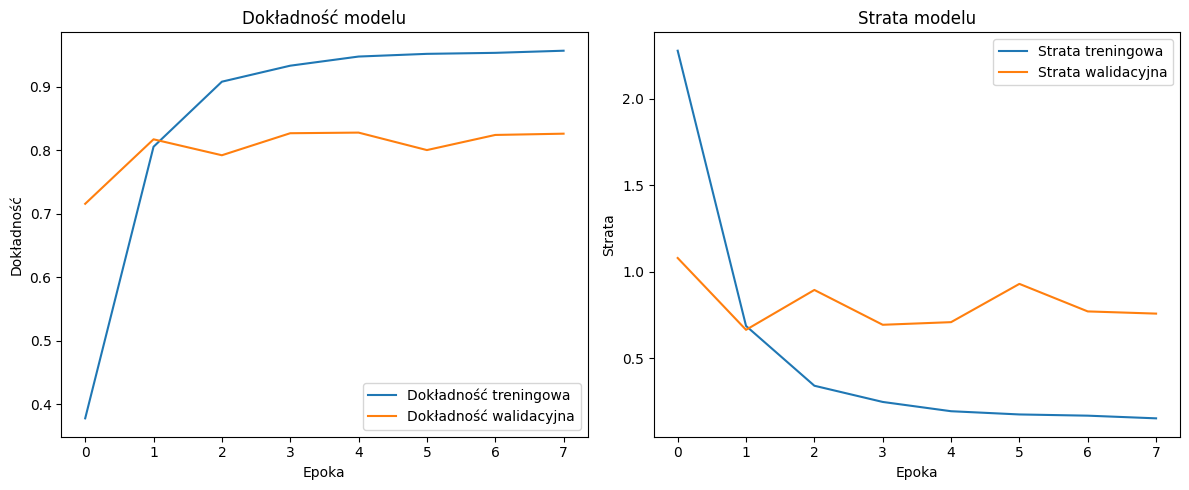

In [5]:
# === SEKCJA 5: WIZUALIZACJA WYNIKÓW TRENINGU ===

# Wykres dokładności
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Dokładność treningowa')
plt.plot(history.history['val_accuracy'], label='Dokładność walidacyjna')
plt.title('Dokładność modelu')
plt.xlabel('Epoka')
plt.ylabel('Dokładność')
plt.legend()

# Wykres straty
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Strata treningowa')
plt.plot(history.history['val_loss'], label='Strata walidacyjna')
plt.title('Strata modelu')
plt.xlabel('Epoka')
plt.ylabel('Strata')
plt.legend()

plt.tight_layout()
plt.show()